In [5]:
! pip install -U scikit-learn
! pip install matplotlib
! pip install pandas
! pip install numpy
! pip install scikit-plot
! pip install scipy==1.11.4
! pip install seaborn

In [6]:
import pickle
import random
import numpy as np
from collections import Counter
from scipy.sparse import csr_matrix
import pandas as pd
import math

In [7]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix
import matplotlib.pyplot as plt

In [8]:
pkl_path = '/Users/shreyanakum/Documents/CS178/CS-178-Project/DATA/tfidf_data.pkl'
classes = ['toxic', 'severe_toxic', 'insult', 'threat', 'obscene', 'identity_hate']
alpha = 1.0
max_iters = 50
convergence_tol = 1e-5
seed = 42
random.seed(seed)
np.random.seed(seed)

# Load Data

In [9]:
# Load data
with open(pkl_path, 'rb') as f:
    tfidf_data = pickle.load(f)

X_train = tfidf_data['X_train'] # scipy sparse
X_test  = tfidf_data['X_test']
y_train_raw = tfidf_data['y_train']
y_test_raw  = tfidf_data['y_test']
vectorizer  = tfidf_data['vectorizer']

# Ensure CSR
X = X_train.tocsr() if hasattr(X_train, 'tocsr') else csr_matrix(X_train)
n_docs, vocab_size = X.shape
C = len(classes)

/Users/shreyanakum/Documents/CS178/CS-178-Project/.venv/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/shreyanakum/Documents/CS178/CS-178-Project/.venv/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Training

## Multi-label setup

In [10]:
# Keep labels as multi-label (no collapsing). Expect a DataFrame with 6 binary columns.
if isinstance(y_train_raw, pd.DataFrame):
    Y = y_train_raw[classes].values.astype(int)
else:
    Y = np.array(y_train_raw).astype(int) # shape (n_docs, 6)
    # if it's not already (n_docs, 6), you may need to adapt this part

n_docs, C_check = Y.shape
assert C_check == C, f"Expected {C} label columns, got {C_check}"

# 1) Hide 10% of positives for each label j
rng = np.random.default_rng(seed)
labeled_mask = np.ones_like(Y, dtype=bool) # True where label is observed

for j in range(C):
    pos_inds = np.where(Y[:, j] == 1)[0]
    if len(pos_inds) == 0:
        continue
    k = max(1, int(0.10 * len(pos_inds)))
    hide = rng.choice(pos_inds, size=k, replace=False)
    labeled_mask[hide, j] = False # these entries become missing for label j

# 2) Initialize responsibilities q_pos[i,j] = P(y_ij = 1 | x_i)
q_pos = np.zeros_like(Y, dtype=float)
for j in range(C):
    for i in range(n_docs):
        if labeled_mask[i, j]:
            q_pos[i, j] = float(Y[i, j]) # 0 or 1 for observed
        else:
            q_pos[i, j] = 0.5 # initial guess for missing labels

## EM per label

In [11]:
X = X.tocsr()
N, V = X.shape

pis        = np.zeros(C) # priors P(y_j = 1)
theta_pos  = np.zeros((C, V)) # P(w=1 | y_j=1)
theta_neg  = np.zeros((C, V)) # P(w=1 | y_j=0)

for j in range(C):
    print(f"\n EM for label '{classes[j]}'")
    q = q_pos[:, j].copy() # shape (N,), fractional label probabilities

    prev_ll = -1e18

    for it in range(1, max_iters + 1):
        # M-step for label j
        N_pos = q.sum()
        N_neg = N - N_pos + 1e-12  # avoid zero

        # prior P(y=1)
        pi_j = (N_pos + 1.0) / (N + 2.0)

        # word presence counts (Bernoulli): treat any non-zero as presence
        wc_pos = np.zeros(V, dtype=float)
        wc_neg = np.zeros(V, dtype=float)

        for i in range(N):
            row = X.getrow(i)
            cols = row.indices
            if row.nnz == 0:
                continue
            p = q[i] # prob y = 1
            wc_pos[cols] += p
            wc_neg[cols] += (1.0 - p)

        # bern NB with Laplace smoothing
        theta_pos_j = (wc_pos + alpha) / (N_pos + 2.0 * alpha + 1e-12)
        theta_neg_j = (wc_neg + alpha) / (N_neg + 2.0 * alpha + 1e-12)

        # e step for label j
        log_pi1 = np.log(pi_j)
        log_pi0 = np.log(1.0 - pi_j)
        log_t1  = np.log(theta_pos_j)
        log_t0  = np.log(theta_neg_j)

        q_new = np.zeros_like(q)
        ll = 0.0

        for i in range(N):
            row = X.getrow(i)
            cols = row.indices

            lp1 = log_pi1
            lp0 = log_pi0

            if row.nnz > 0:
                lp1 += log_t1[cols].sum()
                lp0 += log_t0[cols].sum()

            m = max(lp1, lp0)
            p1 = math.exp(lp1 - m)
            p0 = math.exp(lp0 - m)
            denom = p1 + p0
            p1 /= denom
            p0 /= denom

            # clamp observed labels
            if labeled_mask[i, j]:
                q_new[i] = float(Y[i, j])
            else:
                q_new[i] = p1

            # expected complete-data log-likelihood contribution
            ll += q_new[i] * lp1 + (1.0 - q_new[i]) * lp0

        rel_change = (ll - prev_ll) / (abs(prev_ll) + 1e-12)
        print(f"iter:{it}  ll={ll:.6f} ||| rel_change: {rel_change:.3e}")
        prev_ll = ll
        q = q_new

        if abs(rel_change) < convergence_tol:
            print("Converged")
            break

    pis[j]       = pi_j
    theta_pos[j] = theta_pos_j
    theta_neg[j] = theta_neg_j
    q_pos[:, j]  = q


 EM for label 'toxic'
iter:1  ll=-23138333.080669 ||| rel_change: 1.000e+00
iter:2  ll=-23141812.283706 ||| rel_change: -1.504e-04
iter:3  ll=-23141899.513280 ||| rel_change: -3.769e-06
Converged

 EM for label 'severe_toxic'
iter:1  ll=-23238852.664460 ||| rel_change: 1.000e+00
iter:2  ll=-23238656.621421 ||| rel_change: 8.436e-06
Converged

 EM for label 'insult'
iter:1  ll=-23178683.393021 ||| rel_change: 1.000e+00
iter:2  ll=-23179772.087559 ||| rel_change: -4.697e-05
iter:3  ll=-23179865.470086 ||| rel_change: -4.029e-06
Converged

 EM for label 'threat'
iter:1  ll=-23262628.569771 ||| rel_change: 1.000e+00
iter:2  ll=-23262490.436780 ||| rel_change: 5.938e-06
Converged

 EM for label 'obscene'
iter:1  ll=-23174489.956126 ||| rel_change: 1.000e+00
iter:2  ll=-23174855.518353 ||| rel_change: -1.577e-05
iter:3  ll=-23174946.264038 ||| rel_change: -3.916e-06
Converged

 EM for label 'identity_hate'
iter:1  ll=-23252730.785490 ||| rel_change: 1.000e+00
iter:2  ll=-23252736.877602 |||

## multi label prediction

In [12]:
def predict_multilabel(X_any, pis, theta_pos, theta_neg, threshold=0.5):
    X_any = X_any.tocsr()
    N = X_any.shape[0]
    C = len(pis)
    prob = np.zeros((N, C), dtype=float)

    for j in range(C):
        pi_j = pis[j]
        log_pi1 = np.log(pi_j)
        log_pi0 = np.log(1.0 - pi_j)
        log_t1  = np.log(theta_pos[j])
        log_t0  = np.log(theta_neg[j])

        for i in range(N):
            row = X_any.getrow(i)
            cols = row.indices

            lp1 = log_pi1
            lp0 = log_pi0
            if row.nnz > 0:
                lp1 += log_t1[cols].sum()
                lp0 += log_t0[cols].sum()

            m = max(lp1, lp0)
            p1 = math.exp(lp1 - m)
            p0 = math.exp(lp0 - m)
            prob[i, j] = p1 / (p1 + p0)

    y_pred_bin = (prob >= threshold).astype(int)
    return y_pred_bin, prob

X_test_csr = X_test.tocsr() if hasattr(X_test, 'tocsr') else csr_matrix(X_test)

# Prepare true test labels as binary matrix
if isinstance(y_test_raw, pd.DataFrame):
    Y_test_true = y_test_raw[classes].values.astype(int)
else:
    Y_test_true = np.array(y_test_raw).astype(int)

Y_test_pred, Y_test_prob = predict_multilabel(X_test_csr, pis, theta_pos, theta_neg, threshold=0.5)

# Visualization (Confusion Matrix)


Multi-label classification report (EM NB):
               precision    recall  f1-score   support

        toxic       0.94      0.33      0.49      3056
 severe_toxic       0.40      0.51      0.45       321
       insult       0.80      0.37      0.51      1614
       threat       0.08      0.45      0.13        74
      obscene       0.91      0.43      0.58      1715
identity_hate       0.20      0.31      0.25       294

    micro avg       0.67      0.37      0.48      7074
    macro avg       0.55      0.40      0.40      7074
 weighted avg       0.84      0.37      0.50      7074
  samples avg       0.02      0.03      0.02      7074

Weighted F1: 0.4995
Micro F1:    0.4779
Subset accuracy (exact match): 0.9023

Aggregate Confusion Matrix (all labels combined):
[[183119   1297]
 [  4446   2628]]


/Users/shreyanakum/Documents/CS178/CS-178-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/shreyanakum/Documents/CS178/CS-178-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/shreyanakum/Documents/CS178/CS-178-Project/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to con

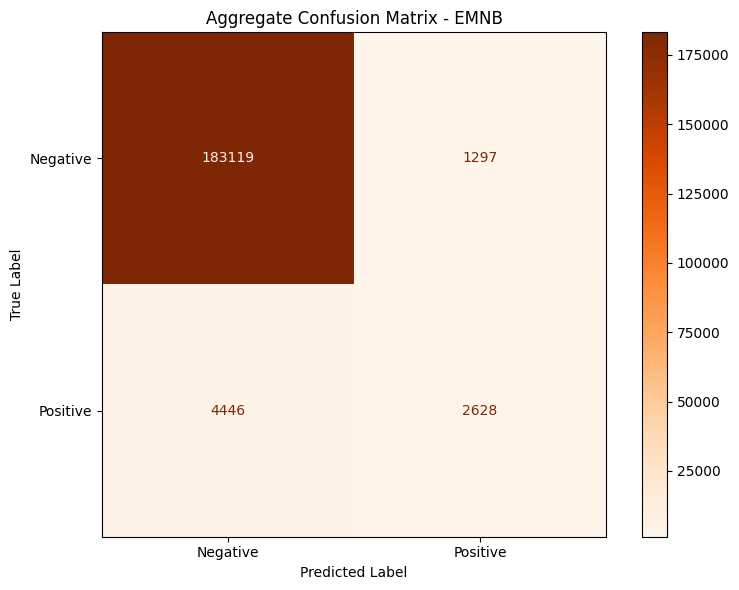

In [13]:
print("\nMulti-label classification report (EM NB):")
print(classification_report(Y_test_true, Y_test_pred, target_names=classes))

weighted_f1 = f1_score(Y_test_true, Y_test_pred, average='weighted')
micro_f1    = f1_score(Y_test_true, Y_test_pred, average='micro')
subset_acc  = accuracy_score(Y_test_true, Y_test_pred)

print(f"Weighted F1: {weighted_f1:.4f}")
print(f"Micro F1:    {micro_f1:.4f}")
print(f"Subset accuracy (exact match): {subset_acc:.4f}")


# Flatten the multi-label arrays (convert DataFrame to numpy array first)
# y_true_flat = Y_test_true.values.ravel()
# y_pred_flat = Y_test_pred.ravel()

cm = confusion_matrix(Y_test_true.flat, Y_test_pred.flat, labels=[0, 1])
print("\nAggregate Confusion Matrix (all labels combined):")
print(cm)

fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(ax=ax, cmap='Oranges', values_format='d')
plt.title('Aggregate Confusion Matrix - EMNB')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()